# TODO

- Focal lossのチューニング

# Setting

In [2]:
import sys

import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt

root_dir = "../../"
if root_dir not in sys.path:
    sys.path.append(root_dir)
from modules import config as cfg
from modules import utils, preprosess, training, predict, metrics

exp = "exp13"
utils.set_seed(cfg.Params.seed)

# Read data

In [3]:
train, test, submit = utils.get_data(debug_mode=False)

# Preprocessing

## Split fold

In [4]:
train = preprosess.assign_stratified_k_fold(train, "MIS_Status")

## Convert

In [5]:
# 地名を座標に変換
train = preprosess.convert_to_latlon(train)
test  = preprosess.convert_to_latlon(test)

# testのBankStateの"PR"はtrainにないため，一番多いCAに変換
test = test.with_columns(pl.col("BankState").str.replace("PR", "CA"))

# DisbursementDateとApprovalDateをYear(数値)に変換
cols  = ["DisbursementDate", "ApprovalDate"]
train = preprosess.convert_date_to_year(train, cols)
test  = preprosess.convert_date_to_year(test, cols)

# 金額データの数値化
cols  = ["DisbursementGross",  "GrAppv", "SBA_Appv"]
train = preprosess.convert_money_data(train, cols)
test  = preprosess.convert_money_data(test, cols)

# 一致しているか
eqs = [
    ["State", "BankState"],
]
train = preprosess.add_eq(train, eqs)
test  = preprosess.add_eq(test, eqs)

# 差の計算
diffs = [
    ["DisbursementGross", "GrAppv"],   # 支払われた額 vs 銀行承認額
    ["DisbursementGross", "SBA_Appv"], # 支払われた額 vs SBA承認額
    ["GrAppv", "SBA_Appv"],            # 銀行承認額 vs SBA承認額
]
train = preprosess.add_diff(train, diffs)
test  = preprosess.add_diff(test, diffs)

# DisbursementDateとApprovalDateの差を計算
train = preprosess.add_diff_disbursement_with_approval(train)
test  = preprosess.add_diff_disbursement_with_approval(test)

# 割合の計算
divs = [
    # ["DisbursementGross", "Term"],
    ["GrAppv", "Term"],
    ["SBA_Appv", "Term"],
    ["NoEmp", "Term"],
    # ["DisbursementGross", "NoEmp"],
    # ["GrAppv", "NoEmp"],
    # ["SBA_Appv", "NoEmp"],
    ["DisbursementGross_GrAppv_diff", "Term"],
    ["DisbursementGross_SBA_Appv_diff", "Term"],
    ["GrAppv_SBA_Appv_diff", "Term"],
    # ["DisbursementGross_GrAppv_diff", "NoEmp"],
    # ["DisbursementGross_SBA_Appv_diff", "NoEmp"],
    # ["GrAppv_SBA_Appv_diff", "NoEmp"]
]
train = preprosess.add_div(train, divs)
test  = preprosess.add_div(test, divs)

# Sectorを職業別にする
train = preprosess.unify_same_sector(train)
test  = preprosess.unify_same_sector(test)

## Target encoding

In [6]:
cols = [
    # "Sector",
    "UrbanRural",
    "RevLineCr",
    "LowDoc",
    "FranchiseCode",
]
target_col = "MIS_Status"
train, test = preprosess.target_encoding(train, test, cols)

## Label encoding
CVによるtarget encodingでは同じカテゴリカル変数に異なる値が割り当てられるのでlabel encodingを併用する

In [7]:
cols = ["RevLineCr", "LowDoc"]
train, test = preprosess.label_encoding(train, test, cols)

# Drop columns

In [8]:
# 不要なカラムの削除
del_cols = [
    # 地名系
    "City",
    "State",
    "BankState",
    # d-b-y系
    "DisbursementDate",
    "ApprovalDate",
    "ApprovalFY",
    # ラベルエンコーディング済み
    "RevLineCr",
    "LowDoc",
]
train = train.drop(del_cols)
test  = test.drop(del_cols)

# Training + Tuning

In [10]:
lgb_params = {
    'objective': 'binary',
    'metric': 'custom',
    'boosting_type': 'gbdt',
    'seed': cfg.Params.seed,
    'learning_rate': cfg.Params.learning_rate,
}

alpha_li = [0.1, 0.2, 0.3, 0.4, 0.5]
gamma_li = [1.0, 2.0, 3.0, 4.0, 5.0]

threshold = 0.5
results_df = pl.DataFrame([
        pl.Series("alpha", [], dtype=pl.Float64),
        pl.Series("gamma", [], dtype=pl.Float64),
        pl.Series("score", [], dtype=pl.Float64)
])
for alpha in alpha_li:
    for gamma in gamma_li:
        oof, models = training.fit_lgbm_fl(train, lgb_params=lgb_params, alpha=alpha, gamma=gamma)
        oof_truth = train[cfg.Cols.target].to_numpy()
        oof_hat = predict.predict_class(oof, threshold=threshold)
        cv_score = metrics.macro_f1_score(oof_truth, oof_hat)
        results_df = results_df.vstack(pl.DataFrame({"alpha": [alpha], "gamma": [gamma], "score": [cv_score]}))

--------------------------------------------------------------------------------
START fold 1
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007923 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5177
[LightGBM] [Info] Number of data points in the train set: 33845, number of used features: 35
[LightGBM] [Warning] Using self-defined objective function
Training until validation scores don't improve for 100 rounds


/Users/taichi/anaconda3/envs/kaggle/lib/python3.9/site-packages/bokbokbok/utils/functions.py:16: RuntimeWarning: overflow encountered in exp
  yhat = 1. / (1. + np.exp(-yhat))


[100]	training's Focal_alpha0.1_gamma1.0: 0.365233	valid_1's Focal_alpha0.1_gamma1.0: 0.868078
Did not meet early stopping. Best iteration is:
[34]	training's Focal_alpha0.1_gamma1.0: 0.0435572	valid_1's Focal_alpha0.1_gamma1.0: 0.24732
Time:  4.573[s]
--------------------------------------------------------------------------------
START fold 2


/Users/taichi/anaconda3/envs/kaggle/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013629 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5184
[LightGBM] [Info] Number of data points in the train set: 33845, number of used features: 35
[LightGBM] [Warning] Using self-defined objective function
Training until validation scores don't improve for 100 rounds
[100]	training's Focal_alpha0.1_gamma1.0: 0.124496	valid_1's Focal_alpha0.1_gamma1.0: 0.544385
Did not meet early stopping. Best iteration is:
[54]	training's Focal_alpha0.1_gamma1.0: 0.0452701	valid_1's Focal_alpha0.1_gamma1.0: 0.282723
Time:  6.215[s]
--------------------------------------------------------------------------------
START fold 3
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029832 seconds.
You can set `f

/Users/taichi/anaconda3/envs/kaggle/lib/python3.9/site-packages/bokbokbok/utils/functions.py:16: RuntimeWarning: overflow encountered in exp
  yhat = 1. / (1. + np.exp(-yhat))


[100]	training's Focal_alpha0.1_gamma2.0: 1.35746	valid_1's Focal_alpha0.1_gamma2.0: 1.59825
Did not meet early stopping. Best iteration is:
[19]	training's Focal_alpha0.1_gamma2.0: 0.0285623	valid_1's Focal_alpha0.1_gamma2.0: 0.146119
Time:  3.575[s]
--------------------------------------------------------------------------------
START fold 2


/Users/taichi/anaconda3/envs/kaggle/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008639 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5184
[LightGBM] [Info] Number of data points in the train set: 33845, number of used features: 35
[LightGBM] [Warning] Using self-defined objective function
Training until validation scores don't improve for 100 rounds
[100]	training's Focal_alpha0.1_gamma2.0: 1.61259	valid_1's Focal_alpha0.1_gamma2.0: 1.71974
Did not meet early stopping. Best iteration is:
[7]	training's Focal_alpha0.1_gamma2.0: 0.0297933	valid_1's Focal_alpha0.1_gamma2.0: 0.0733323
Time:  4.864[s]
--------------------------------------------------------------------------------
START fold 3
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009405 seconds.
You can set `for

/Users/taichi/anaconda3/envs/kaggle/lib/python3.9/site-packages/bokbokbok/utils/functions.py:16: RuntimeWarning: overflow encountered in exp
  yhat = 1. / (1. + np.exp(-yhat))


[100]	training's Focal_alpha0.1_gamma3.0: 2.83657	valid_1's Focal_alpha0.1_gamma3.0: 3.08951
Did not meet early stopping. Best iteration is:
[2]	training's Focal_alpha0.1_gamma3.0: 0.0171413	valid_1's Focal_alpha0.1_gamma3.0: 0.0454065
Time:  4.175[s]
--------------------------------------------------------------------------------
START fold 2


/Users/taichi/anaconda3/envs/kaggle/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016728 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5184
[LightGBM] [Info] Number of data points in the train set: 33845, number of used features: 35
[LightGBM] [Warning] Using self-defined objective function
Training until validation scores don't improve for 100 rounds
[100]	training's Focal_alpha0.1_gamma3.0: 2.93543	valid_1's Focal_alpha0.1_gamma3.0: 3.35406
Did not meet early stopping. Best iteration is:
[1]	training's Focal_alpha0.1_gamma3.0: 0.0171044	valid_1's Focal_alpha0.1_gamma3.0: 0.0243289
Time:  5.787[s]
--------------------------------------------------------------------------------
START fold 3
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009957 seconds.
You can set `for

/Users/taichi/anaconda3/envs/kaggle/lib/python3.9/site-packages/bokbokbok/utils/functions.py:16: RuntimeWarning: overflow encountered in exp
  yhat = 1. / (1. + np.exp(-yhat))


[100]	training's Focal_alpha0.1_gamma4.0: 4.31117	valid_1's Focal_alpha0.1_gamma4.0: 4.30977
Did not meet early stopping. Best iteration is:
[1]	training's Focal_alpha0.1_gamma4.0: 0.00982312	valid_1's Focal_alpha0.1_gamma4.0: 0.0319442
Time:  3.918[s]
--------------------------------------------------------------------------------
START fold 2


/Users/taichi/anaconda3/envs/kaggle/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009282 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5184
[LightGBM] [Info] Number of data points in the train set: 33845, number of used features: 35
[LightGBM] [Warning] Using self-defined objective function
Training until validation scores don't improve for 100 rounds
[100]	training's Focal_alpha0.1_gamma4.0: 3.91932	valid_1's Focal_alpha0.1_gamma4.0: 4.27515
Did not meet early stopping. Best iteration is:
[1]	training's Focal_alpha0.1_gamma4.0: 0.00949822	valid_1's Focal_alpha0.1_gamma4.0: 0.0164827
Time:  3.662[s]
--------------------------------------------------------------------------------
START fold 3
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threadin

/Users/taichi/anaconda3/envs/kaggle/lib/python3.9/site-packages/bokbokbok/utils/functions.py:16: RuntimeWarning: overflow encountered in exp
  yhat = 1. / (1. + np.exp(-yhat))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No furthe

/Users/taichi/anaconda3/envs/kaggle/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010995 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5184
[LightGBM] [Info] Number of data points in the train set: 33845, number of used features: 35
[LightGBM] [Warning] Using self-defined objective function
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[100]	training's Focal_alpha0.1_gamma5.0: 3.50647	valid_1's Focal_alpha0.1_gamma5.0: 3.66593
Did not meet early stopping. Best iteration is:
[1]	training's Focal_alpha0.1_gamma5.0: 0.0056886	valid_1's Focal_alpha0.1_gamma5.0: 0.0121458
Time:  4.052[s]
--------------------------------------------------------------------------------
START fold 3
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing row-wise mult

/Users/taichi/anaconda3/envs/kaggle/lib/python3.9/site-packages/bokbokbok/utils/functions.py:16: RuntimeWarning: overflow encountered in exp
  yhat = 1. / (1. + np.exp(-yhat))


[100]	training's Focal_alpha0.2_gamma1.0: 1.5084	valid_1's Focal_alpha0.2_gamma1.0: 1.84502
Did not meet early stopping. Best iteration is:
[32]	training's Focal_alpha0.2_gamma1.0: 0.0656854	valid_1's Focal_alpha0.2_gamma1.0: 0.359874
Time:  3.776[s]
--------------------------------------------------------------------------------
START fold 2


/Users/taichi/anaconda3/envs/kaggle/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007155 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5184
[LightGBM] [Info] Number of data points in the train set: 33845, number of used features: 35
[LightGBM] [Warning] Using self-defined objective function
Training until validation scores don't improve for 100 rounds
[100]	training's Focal_alpha0.2_gamma1.0: 0.650327	valid_1's Focal_alpha0.2_gamma1.0: 1.0813
Did not meet early stopping. Best iteration is:
[32]	training's Focal_alpha0.2_gamma1.0: 0.069424	valid_1's Focal_alpha0.2_gamma1.0: 0.307543
Time:  3.357[s]
--------------------------------------------------------------------------------
START fold 3
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading,

/Users/taichi/anaconda3/envs/kaggle/lib/python3.9/site-packages/bokbokbok/utils/functions.py:16: RuntimeWarning: overflow encountered in exp
  yhat = 1. / (1. + np.exp(-yhat))


[100]	training's Focal_alpha0.2_gamma2.0: 1.60143	valid_1's Focal_alpha0.2_gamma2.0: 1.73868
Did not meet early stopping. Best iteration is:
[6]	training's Focal_alpha0.2_gamma2.0: 0.0448094	valid_1's Focal_alpha0.2_gamma2.0: 0.139674
Time:  4.284[s]
--------------------------------------------------------------------------------
START fold 2


/Users/taichi/anaconda3/envs/kaggle/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011702 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5184
[LightGBM] [Info] Number of data points in the train set: 33845, number of used features: 35
[LightGBM] [Warning] Using self-defined objective function
Training until validation scores don't improve for 100 rounds
[100]	training's Focal_alpha0.2_gamma2.0: 1.83143	valid_1's Focal_alpha0.2_gamma2.0: 1.7892
Did not meet early stopping. Best iteration is:
[22]	training's Focal_alpha0.2_gamma2.0: 0.0457543	valid_1's Focal_alpha0.2_gamma2.0: 0.185867
Time:  3.559[s]
--------------------------------------------------------------------------------
START fold 3
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009250 seconds.
You can set `forc

/Users/taichi/anaconda3/envs/kaggle/lib/python3.9/site-packages/bokbokbok/utils/functions.py:16: RuntimeWarning: overflow encountered in exp
  yhat = 1. / (1. + np.exp(-yhat))


[100]	training's Focal_alpha0.2_gamma3.0: 4.53118	valid_1's Focal_alpha0.2_gamma3.0: 4.45927
Did not meet early stopping. Best iteration is:
[3]	training's Focal_alpha0.2_gamma3.0: 0.0257884	valid_1's Focal_alpha0.2_gamma3.0: 0.0895795
Time:  4.532[s]
--------------------------------------------------------------------------------
START fold 2


/Users/taichi/anaconda3/envs/kaggle/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010638 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5184
[LightGBM] [Info] Number of data points in the train set: 33845, number of used features: 35
[LightGBM] [Warning] Using self-defined objective function
Training until validation scores don't improve for 100 rounds
[100]	training's Focal_alpha0.2_gamma3.0: 4.36435	valid_1's Focal_alpha0.2_gamma3.0: 4.56558
Did not meet early stopping. Best iteration is:
[1]	training's Focal_alpha0.2_gamma3.0: 0.0264206	valid_1's Focal_alpha0.2_gamma3.0: 0.0412545
Time:  3.879[s]
--------------------------------------------------------------------------------
START fold 3
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009713 seconds.
You can set `for

/Users/taichi/anaconda3/envs/kaggle/lib/python3.9/site-packages/bokbokbok/utils/functions.py:16: RuntimeWarning: overflow encountered in exp
  yhat = 1. / (1. + np.exp(-yhat))


[100]	training's Focal_alpha0.2_gamma4.0: 4.72522	valid_1's Focal_alpha0.2_gamma4.0: 4.65597
Did not meet early stopping. Best iteration is:
[2]	training's Focal_alpha0.2_gamma4.0: 0.0160136	valid_1's Focal_alpha0.2_gamma4.0: 0.0685556
Time:  4.429[s]
--------------------------------------------------------------------------------
START fold 2


/Users/taichi/anaconda3/envs/kaggle/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024136 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5184
[LightGBM] [Info] Number of data points in the train set: 33845, number of used features: 35
[LightGBM] [Warning] Using self-defined objective function
Training until validation scores don't improve for 100 rounds
[100]	training's Focal_alpha0.2_gamma4.0: 4.8755	valid_1's Focal_alpha0.2_gamma4.0: 4.98592
Did not meet early stopping. Best iteration is:
[1]	training's Focal_alpha0.2_gamma4.0: 0.0160163	valid_1's Focal_alpha0.2_gamma4.0: 0.0305166
Time:  4.521[s]
--------------------------------------------------------------------------------
START fold 3
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009294 seconds.
You can set `forc

/Users/taichi/anaconda3/envs/kaggle/lib/python3.9/site-packages/bokbokbok/utils/functions.py:16: RuntimeWarning: overflow encountered in exp
  yhat = 1. / (1. + np.exp(-yhat))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[100]	training's Focal_alpha0.2_gamma5.0: 3.85934	valid_1's Focal_alpha0.2_gamma5.0: 3.83887
Did not meet early stopping. Best iteration is:
[1]	training's Focal_alpha0.2_gamma5.0: 0.0111981	valid_1's Focal_alpha0.2_gamma5.0: 0.055538
Time:  3.859[s]
--------------------------------------------------------------------------------
START fold 2


/Users/taichi/anaconda3/envs/kaggle/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011509 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5184
[LightGBM] [Info] Number of data points in the train set: 33845, number of used features: 35
[LightGBM] [Warning] Using self-defined objective function
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because the

/Users/taichi/anaconda3/envs/kaggle/lib/python3.9/site-packages/bokbokbok/utils/functions.py:16: RuntimeWarning: overflow encountered in exp
  yhat = 1. / (1. + np.exp(-yhat))


[100]	training's Focal_alpha0.3_gamma1.0: 1.5034	valid_1's Focal_alpha0.3_gamma1.0: 2.08757
Did not meet early stopping. Best iteration is:
[48]	training's Focal_alpha0.3_gamma1.0: 0.0937695	valid_1's Focal_alpha0.3_gamma1.0: 0.539701
Time:  3.636[s]
--------------------------------------------------------------------------------
START fold 2


/Users/taichi/anaconda3/envs/kaggle/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005057 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5184
[LightGBM] [Info] Number of data points in the train set: 33845, number of used features: 35
[LightGBM] [Warning] Using self-defined objective function
Training until validation scores don't improve for 100 rounds
[100]	training's Focal_alpha0.3_gamma1.0: 1.47515	valid_1's Focal_alpha0.3_gamma1.0: 1.92297
Did not meet early stopping. Best iteration is:
[1]	training's Focal_alpha0.3_gamma1.0: 0.107872	valid_1's Focal_alpha0.3_gamma1.0: 0.133309
Time:  3.699[s]
--------------------------------------------------------------------------------
START fold 3
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, 

/Users/taichi/anaconda3/envs/kaggle/lib/python3.9/site-packages/bokbokbok/utils/functions.py:16: RuntimeWarning: overflow encountered in exp
  yhat = 1. / (1. + np.exp(-yhat))


[100]	training's Focal_alpha0.3_gamma2.0: 4.24189	valid_1's Focal_alpha0.3_gamma2.0: 4.08815
Did not meet early stopping. Best iteration is:
[1]	training's Focal_alpha0.3_gamma2.0: 0.0619427	valid_1's Focal_alpha0.3_gamma2.0: 0.125902
Time:  3.859[s]
--------------------------------------------------------------------------------
START fold 2


/Users/taichi/anaconda3/envs/kaggle/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012141 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5184
[LightGBM] [Info] Number of data points in the train set: 33845, number of used features: 35
[LightGBM] [Warning] Using self-defined objective function
Training until validation scores don't improve for 100 rounds
[100]	training's Focal_alpha0.3_gamma2.0: 3.34134	valid_1's Focal_alpha0.3_gamma2.0: 3.19231
Did not meet early stopping. Best iteration is:
[1]	training's Focal_alpha0.3_gamma2.0: 0.0608232	valid_1's Focal_alpha0.3_gamma2.0: 0.0838655
Time:  4.704[s]
--------------------------------------------------------------------------------
START fold 3
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010514 seconds.
You can set `for

/Users/taichi/anaconda3/envs/kaggle/lib/python3.9/site-packages/bokbokbok/utils/functions.py:16: RuntimeWarning: overflow encountered in exp
  yhat = 1. / (1. + np.exp(-yhat))


[100]	training's Focal_alpha0.3_gamma3.0: 4.27666	valid_1's Focal_alpha0.3_gamma3.0: 4.17979
Did not meet early stopping. Best iteration is:
[1]	training's Focal_alpha0.3_gamma3.0: 0.0377706	valid_1's Focal_alpha0.3_gamma3.0: 0.100341
Time:  3.812[s]
--------------------------------------------------------------------------------
START fold 2


/Users/taichi/anaconda3/envs/kaggle/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014737 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5184
[LightGBM] [Info] Number of data points in the train set: 33845, number of used features: 35
[LightGBM] [Warning] Using self-defined objective function
Training until validation scores don't improve for 100 rounds
[100]	training's Focal_alpha0.3_gamma3.0: 5.09276	valid_1's Focal_alpha0.3_gamma3.0: 5.32674
Did not meet early stopping. Best iteration is:
[1]	training's Focal_alpha0.3_gamma3.0: 0.0371178	valid_1's Focal_alpha0.3_gamma3.0: 0.0591464
Time:  4.226[s]
--------------------------------------------------------------------------------
START fold 3
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005742 seconds.
You can set `for

/Users/taichi/anaconda3/envs/kaggle/lib/python3.9/site-packages/bokbokbok/utils/functions.py:16: RuntimeWarning: overflow encountered in exp
  yhat = 1. / (1. + np.exp(-yhat))


[100]	training's Focal_alpha0.3_gamma4.0: 5.62385	valid_1's Focal_alpha0.3_gamma4.0: 6.26463
Did not meet early stopping. Best iteration is:
[1]	training's Focal_alpha0.3_gamma4.0: 0.0250134	valid_1's Focal_alpha0.3_gamma4.0: 0.0868487
Time:  3.748[s]
--------------------------------------------------------------------------------
START fold 2


/Users/taichi/anaconda3/envs/kaggle/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009966 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5184
[LightGBM] [Info] Number of data points in the train set: 33845, number of used features: 35
[LightGBM] [Warning] Using self-defined objective function
Training until validation scores don't improve for 100 rounds
[100]	training's Focal_alpha0.3_gamma4.0: 5.54005	valid_1's Focal_alpha0.3_gamma4.0: 5.30189
Did not meet early stopping. Best iteration is:
[1]	training's Focal_alpha0.3_gamma4.0: 0.024548	valid_1's Focal_alpha0.3_gamma4.0: 0.0460582
Time:  3.733[s]
--------------------------------------------------------------------------------
START fold 3
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009232 seconds.
You can set `forc

/Users/taichi/anaconda3/envs/kaggle/lib/python3.9/site-packages/bokbokbok/utils/functions.py:16: RuntimeWarning: overflow encountered in exp
  yhat = 1. / (1. + np.exp(-yhat))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, 

/Users/taichi/anaconda3/envs/kaggle/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009224 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5184
[LightGBM] [Info] Number of data points in the train set: 33845, number of used features: 35
[LightGBM] [Warning] Using self-defined objective function
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning]

/Users/taichi/anaconda3/envs/kaggle/lib/python3.9/site-packages/bokbokbok/utils/functions.py:16: RuntimeWarning: overflow encountered in exp
  yhat = 1. / (1. + np.exp(-yhat))


[100]	training's Focal_alpha0.4_gamma1.0: 3.18135	valid_1's Focal_alpha0.4_gamma1.0: 3.53412
Did not meet early stopping. Best iteration is:
[1]	training's Focal_alpha0.4_gamma1.0: 0.128596	valid_1's Focal_alpha0.4_gamma1.0: 0.202962
Time:  3.385[s]
--------------------------------------------------------------------------------
START fold 2


/Users/taichi/anaconda3/envs/kaggle/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015778 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5184
[LightGBM] [Info] Number of data points in the train set: 33845, number of used features: 35
[LightGBM] [Warning] Using self-defined objective function
Training until validation scores don't improve for 100 rounds
[100]	training's Focal_alpha0.4_gamma1.0: 3.34107	valid_1's Focal_alpha0.4_gamma1.0: 3.84994
Did not meet early stopping. Best iteration is:
[1]	training's Focal_alpha0.4_gamma1.0: 0.126285	valid_1's Focal_alpha0.4_gamma1.0: 0.155908
Time:  3.903[s]
--------------------------------------------------------------------------------
START fold 3
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009066 seconds.
You can set `force

/Users/taichi/anaconda3/envs/kaggle/lib/python3.9/site-packages/bokbokbok/utils/functions.py:16: RuntimeWarning: overflow encountered in exp
  yhat = 1. / (1. + np.exp(-yhat))


[100]	training's Focal_alpha0.4_gamma2.0: 4.93395	valid_1's Focal_alpha0.4_gamma2.0: 5.20627
Did not meet early stopping. Best iteration is:
[1]	training's Focal_alpha0.4_gamma2.0: 0.0767334	valid_1's Focal_alpha0.4_gamma2.0: 0.150032
Time:  3.648[s]
--------------------------------------------------------------------------------
START fold 2


/Users/taichi/anaconda3/envs/kaggle/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015941 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5184
[LightGBM] [Info] Number of data points in the train set: 33845, number of used features: 35
[LightGBM] [Warning] Using self-defined objective function
Training until validation scores don't improve for 100 rounds
[100]	training's Focal_alpha0.4_gamma2.0: 5.02687	valid_1's Focal_alpha0.4_gamma2.0: 5.46475
Did not meet early stopping. Best iteration is:
[1]	training's Focal_alpha0.4_gamma2.0: 0.0760676	valid_1's Focal_alpha0.4_gamma2.0: 0.104461
Time:  3.707[s]
--------------------------------------------------------------------------------
START fold 3
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021393 seconds.
You can set `forc

/Users/taichi/anaconda3/envs/kaggle/lib/python3.9/site-packages/bokbokbok/utils/functions.py:16: RuntimeWarning: overflow encountered in exp
  yhat = 1. / (1. + np.exp(-yhat))


[100]	training's Focal_alpha0.4_gamma3.0: 4.73473	valid_1's Focal_alpha0.4_gamma3.0: 4.79919
Did not meet early stopping. Best iteration is:
[1]	training's Focal_alpha0.4_gamma3.0: 0.0500962	valid_1's Focal_alpha0.4_gamma3.0: 0.122461
Time:  6.430[s]
--------------------------------------------------------------------------------
START fold 2


/Users/taichi/anaconda3/envs/kaggle/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.032811 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5184
[LightGBM] [Info] Number of data points in the train set: 33845, number of used features: 35
[LightGBM] [Warning] Using self-defined objective function
Training until validation scores don't improve for 100 rounds
[100]	training's Focal_alpha0.4_gamma3.0: 5.69276	valid_1's Focal_alpha0.4_gamma3.0: 6.07134
Did not meet early stopping. Best iteration is:
[1]	training's Focal_alpha0.4_gamma3.0: 0.0502124	valid_1's Focal_alpha0.4_gamma3.0: 0.0783925
Time:  11.521[s]
--------------------------------------------------------------------------------
START fold 3
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031897 seconds.
You can set `fo

/Users/taichi/anaconda3/envs/kaggle/lib/python3.9/site-packages/bokbokbok/utils/functions.py:16: RuntimeWarning: overflow encountered in exp
  yhat = 1. / (1. + np.exp(-yhat))


[100]	training's Focal_alpha0.4_gamma4.0: 6.17325	valid_1's Focal_alpha0.4_gamma4.0: 6.88639
Did not meet early stopping. Best iteration is:
[1]	training's Focal_alpha0.4_gamma4.0: 0.035487	valid_1's Focal_alpha0.4_gamma4.0: 0.10742
Time:  4.460[s]
--------------------------------------------------------------------------------
START fold 2


/Users/taichi/anaconda3/envs/kaggle/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010091 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5184
[LightGBM] [Info] Number of data points in the train set: 33845, number of used features: 35
[LightGBM] [Warning] Using self-defined objective function
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning]

/Users/taichi/anaconda3/envs/kaggle/lib/python3.9/site-packages/bokbokbok/utils/functions.py:16: RuntimeWarning: overflow encountered in exp
  yhat = 1. / (1. + np.exp(-yhat))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

/Users/taichi/anaconda3/envs/kaggle/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010071 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5184
[LightGBM] [Info] Number of data points in the train set: 33845, number of used features: 35
[LightGBM] [Warning] Using self-defined objective function
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning]

/Users/taichi/anaconda3/envs/kaggle/lib/python3.9/site-packages/bokbokbok/utils/functions.py:16: RuntimeWarning: overflow encountered in exp
  yhat = 1. / (1. + np.exp(-yhat))


[100]	training's Focal_alpha0.5_gamma1.0: 6.93681	valid_1's Focal_alpha0.5_gamma1.0: 7.30523
Did not meet early stopping. Best iteration is:
[1]	training's Focal_alpha0.5_gamma1.0: 0.147104	valid_1's Focal_alpha0.5_gamma1.0: 0.225113
Time:  9.056[s]
--------------------------------------------------------------------------------
START fold 2


/Users/taichi/anaconda3/envs/kaggle/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033154 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5184
[LightGBM] [Info] Number of data points in the train set: 33845, number of used features: 35
[LightGBM] [Warning] Using self-defined objective function
Training until validation scores don't improve for 100 rounds
[100]	training's Focal_alpha0.5_gamma1.0: 4.36888	valid_1's Focal_alpha0.5_gamma1.0: 4.21027
Did not meet early stopping. Best iteration is:
[1]	training's Focal_alpha0.5_gamma1.0: 0.144822	valid_1's Focal_alpha0.5_gamma1.0: 0.177398
Time:  7.088[s]
--------------------------------------------------------------------------------
START fold 3
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.037773 seconds.
You can set `force

/Users/taichi/anaconda3/envs/kaggle/lib/python3.9/site-packages/bokbokbok/utils/functions.py:16: RuntimeWarning: overflow encountered in exp
  yhat = 1. / (1. + np.exp(-yhat))


[100]	training's Focal_alpha0.5_gamma2.0: 6.32682	valid_1's Focal_alpha0.5_gamma2.0: 7.06165
Did not meet early stopping. Best iteration is:
[1]	training's Focal_alpha0.5_gamma2.0: 0.0925357	valid_1's Focal_alpha0.5_gamma2.0: 0.17018
Time:  8.337[s]
--------------------------------------------------------------------------------
START fold 2


/Users/taichi/anaconda3/envs/kaggle/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012989 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5184
[LightGBM] [Info] Number of data points in the train set: 33845, number of used features: 35
[LightGBM] [Warning] Using self-defined objective function
Training until validation scores don't improve for 100 rounds
[100]	training's Focal_alpha0.5_gamma2.0: 5.40463	valid_1's Focal_alpha0.5_gamma2.0: 5.35252
Did not meet early stopping. Best iteration is:
[1]	training's Focal_alpha0.5_gamma2.0: 0.0923828	valid_1's Focal_alpha0.5_gamma2.0: 0.123311
Time:  8.209[s]
--------------------------------------------------------------------------------
START fold 3
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009710 seconds.
You can set `forc

/Users/taichi/anaconda3/envs/kaggle/lib/python3.9/site-packages/bokbokbok/utils/functions.py:16: RuntimeWarning: overflow encountered in exp
  yhat = 1. / (1. + np.exp(-yhat))


[100]	training's Focal_alpha0.5_gamma3.0: 5.61046	valid_1's Focal_alpha0.5_gamma3.0: 5.36997
Did not meet early stopping. Best iteration is:
[1]	training's Focal_alpha0.5_gamma3.0: 0.0641548	valid_1's Focal_alpha0.5_gamma3.0: 0.142164
Time:  6.965[s]
--------------------------------------------------------------------------------
START fold 2


/Users/taichi/anaconda3/envs/kaggle/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021129 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5184
[LightGBM] [Info] Number of data points in the train set: 33845, number of used features: 35
[LightGBM] [Warning] Using self-defined objective function
Training until validation scores don't improve for 100 rounds
[100]	training's Focal_alpha0.5_gamma3.0: 7.94582	valid_1's Focal_alpha0.5_gamma3.0: 8.68213
Did not meet early stopping. Best iteration is:
[1]	training's Focal_alpha0.5_gamma3.0: 0.0649418	valid_1's Focal_alpha0.5_gamma3.0: 0.0951993
Time:  6.936[s]
--------------------------------------------------------------------------------
START fold 3
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006656 seconds.
You can set `for

/Users/taichi/anaconda3/envs/kaggle/lib/python3.9/site-packages/bokbokbok/utils/functions.py:16: RuntimeWarning: overflow encountered in exp
  yhat = 1. / (1. + np.exp(-yhat))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the spl

/Users/taichi/anaconda3/envs/kaggle/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008129 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5184
[LightGBM] [Info] Number of data points in the train set: 33845, number of used features: 35
[LightGBM] [Warning] Using self-defined objective function
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

/Users/taichi/anaconda3/envs/kaggle/lib/python3.9/site-packages/bokbokbok/utils/functions.py:16: RuntimeWarning: overflow encountered in exp
  yhat = 1. / (1. + np.exp(-yhat))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No furthe

/Users/taichi/anaconda3/envs/kaggle/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.054241 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5184
[LightGBM] [Info] Number of data points in the train set: 33845, number of used features: 35
[LightGBM] [Warning] Using self-defined objective function
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

In [11]:
results_df

alpha,gamma,score
f64,f64,f64
0.1,1.0,0.533271
0.1,2.0,0.511916
0.1,3.0,0.52295
0.1,4.0,0.55393
0.1,5.0,0.553913
0.2,1.0,0.587359
0.2,2.0,0.614287
0.2,3.0,0.613158
0.2,4.0,0.606373


alpha = 0.2
gamma = 2.0

In [12]:
alpha = 0.2
gamma = 2.0
oof, models = training.fit_lgbm_fl(train, lgb_params=lgb_params, alpha=alpha, gamma=gamma)

--------------------------------------------------------------------------------
START fold 1
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033369 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5177
[LightGBM] [Info] Number of data points in the train set: 33845, number of used features: 35
[LightGBM] [Warning] Using self-defined objective function
Training until validation scores don't improve for 100 rounds


/Users/taichi/anaconda3/envs/kaggle/lib/python3.9/site-packages/bokbokbok/utils/functions.py:16: RuntimeWarning: overflow encountered in exp
  yhat = 1. / (1. + np.exp(-yhat))


[100]	training's Focal_alpha0.2_gamma2.0: 1.60143	valid_1's Focal_alpha0.2_gamma2.0: 1.73868
Did not meet early stopping. Best iteration is:
[6]	training's Focal_alpha0.2_gamma2.0: 0.0448094	valid_1's Focal_alpha0.2_gamma2.0: 0.139674
Time:  6.847[s]
--------------------------------------------------------------------------------
START fold 2


/Users/taichi/anaconda3/envs/kaggle/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008109 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5184
[LightGBM] [Info] Number of data points in the train set: 33845, number of used features: 35
[LightGBM] [Warning] Using self-defined objective function
Training until validation scores don't improve for 100 rounds
[100]	training's Focal_alpha0.2_gamma2.0: 1.83143	valid_1's Focal_alpha0.2_gamma2.0: 1.7892
Did not meet early stopping. Best iteration is:
[22]	training's Focal_alpha0.2_gamma2.0: 0.0457543	valid_1's Focal_alpha0.2_gamma2.0: 0.185867
Time:  6.108[s]
--------------------------------------------------------------------------------
START fold 3
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011476 seconds.
You can set `forc

# Predict

In [23]:
threshold = 0.5

In [24]:
pred_prob = predict.predict_probability_sigmoid(models, test)
pred_class = predict.predict_class(pred_prob, threshold=threshold)

## CV score

In [25]:
oof_truth = train[cfg.Cols.target].to_numpy()
oof_hat = predict.predict_class(oof, threshold=threshold)
cv_score = metrics.macro_f1_score(oof_truth, oof_hat)
print(cv_score)

0.614287119545442


## Check result

### oofとtestの予測値分布を比較してバグを確認

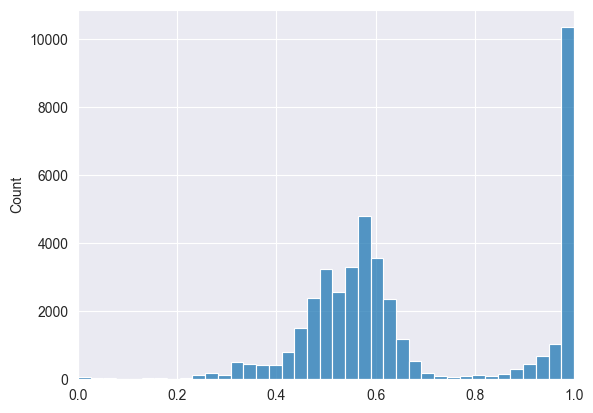

In [16]:
sns.histplot(oof)
plt.xlim(0.0, 1.0)
plt.show()

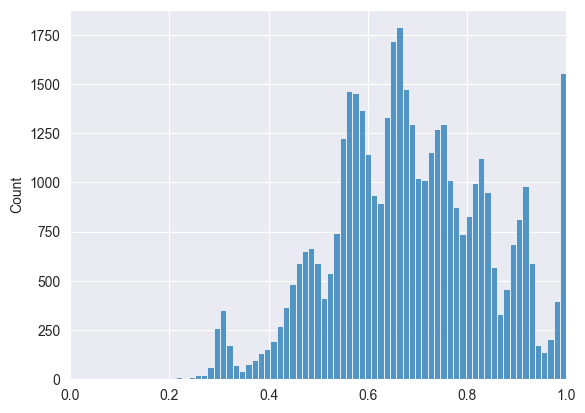

In [17]:
sns.histplot(pred_prob)
plt.xlim(0.0, 1.0)
plt.show()

### 予測値の1の割合を確認

In [26]:
print(pred_class.sum() / len(pred_class))

0.8786990640068072


### oofにおける混同行列を確認

True Negative Rate (0の正解率): 0.51
True Positive Rate (1の正解率): 0.83


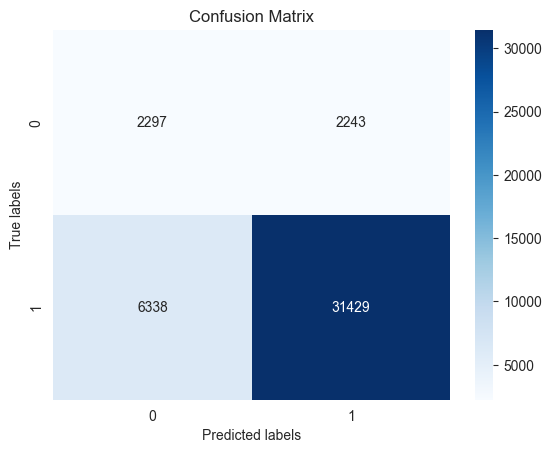

In [27]:
metrics.show_confusion_matrix(oof_truth, oof_hat)

## Submit

In [28]:
submit = submit.with_columns([pl.Series(cfg.Cols.sub_pred, pred_class)])
utils.make_submission(submit, exp, cv_score)